In [1]:
!pip install torchtext==0.11.2

In [2]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe


In [3]:
from torchtext.vocab import GloVe

glove = GloVe(name="twitter.27B", dim=25)

# glove.twitter.27B.25d

# glove = GloVe(name='6B')


.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [00:24<00:00, 49621.04it/s]


In [4]:
from torchtext.vocab import GloVe
from itertools import combinations
from torchtext import vocab

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

if device == 'cpu':
    VECTORS_CACHE_DIR = '/Users/sophiamlawer/.vector_cache'
    # Please change above to your cache
else:
    VECTORS_CACHE_DIR = './.vector_cache'
    # This is the default cache on Colab. Caching may not work
    # as expected on Colab.



glove = vocab.GloVe(name="twitter.27B", dim=25,cache=VECTORS_CACHE_DIR)

In [5]:
## Read in data
import pandas as pd 

df_train = pd.read_csv("hate_train.csv")
df_test = pd.read_csv("hate_test.csv")
df_val = pd.read_csv("hate_val.csv")

print(df_train.shape)
df_train.head()

(22373, 9)


,Unnamed: 0,Unnamed: 0.1,id,label,tweet,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,27857,27857,27858,0,"omg. omg. omg. yay! i found it, and at a wond...","['segasaturn', 'throwbackâ']",omg omg omg yay found wonderful price segasatu...,"omg. omg. omg. yay! i found it, and at a wond...",omg omg omg yay found wonderful price segasatu...
1,31205,31205,31206,0,#payintheusa polar bear climb racing: angry ...,['payintheusa'],payintheusa polar bear climb racing angry pola...,<hashtag> payintheusa <elong>polar bear climb...,payintheusa polar bear climb racing angry pola...
2,8440,8440,8441,0,#trainhard polar bear climb racing: angry po...,['trainhard'],trainhard polar bear climb racing angry polar ...,<hashtag> trainhard <elong>polar bear climb r...,trainhard polar bear climb racing angry polar ...
3,5005,5005,5006,1,he should turn in his resignation.,[],turn resignation,he should turn in his resignation.,turn resignation
4,3898,3898,3899,0,ððð . . happy bihday!! to hajime hoso...,"['bihday', '30æ', 'ã']",happy bihday hajime hosogai bihday bihday 30,ððð . . happy bihday! <repeat> to haj...,. . happy bihday hajime hosogai . . . bihday b...


In [6]:
df_train = df_train[df_train['clean_tweet'].notna()]
df_test = df_test[df_test['clean_tweet'].notna()]
df_val = df_val[df_val['clean_tweet'].notna()]

df_train[["clean_tweet", "label"]].to_csv("train.csv")
df_test[["clean_tweet", "label"]].to_csv("test.csv")
df_val[["clean_tweet", "label"]].to_csv("val.csv")

In [7]:
df_train[["clean_tweet", "label"]]

,clean_tweet,label
0,omg omg omg yay found wonderful price segasatu...,0
1,payintheusa polar bear climb racing angry pola...,0
2,trainhard polar bear climb racing angry polar ...,0
3,turn resignation,1
4,happy bihday hajime hosogai bihday bihday 30,0
...,...,...
22368,fallschurch gorilla simulator need adapt envir...,0
22369,taylor cried cuz found phone emotional times o...,0
22370,factsguide people nowadays motivation,0
22371,mrs reid working p6s today preparation p7s hig...,0


## Try This Model

In [8]:
from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator, Iterator

TEXT = Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = Field(sequential=False, use_vocab=False, dtype = torch.float,batch_first=True)

In [9]:
fields = [('label', LABEL), ('clean_tweet',TEXT)]


In [10]:
train, val, test = TabularDataset.splits(path = "/content/", train='train.csv',validation='val.csv',
                                         test='test.csv', format='csv',
                                         fields= fields, skip_header=True)

print(vars(train.examples[0]))

{'label': '0', 'clean_tweet': ['omg', 'omg', 'omg', 'yay', 'found', 'wonderful', 'price', 'segasaturn', 'throwback']}


In [12]:
TEXT.build_vocab(train,min_freq=3,vectors = "glove.twitter.27B.25d")  
# LABEL.build_vocab(train)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
# print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  
# print(LABEL.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 7559
[('love', 1886), ('nt', 1708), ('day', 1617), ('happy', 1163), ('i', 1027), ('m', 839), ('life', 810), ('time', 804), ('like', 737), ('today', 708)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fd5161b3b10>>, {'<unk>': 0, '<pad>': 1, 'love': 2, 'nt': 3, 'day': 4, 'happy': 5, 'i': 6, 'm': 7, 'life': 8, 'time': 9, 'like': 10, 'today': 11, 'new': 12, 'thankful': 13, 'positive': 14, 'get': 15, 'bihday': 16, 'people': 17, 'good': 18, 'ca': 19, 'one': 20, 'see': 21, 'fathers': 22, 'do': 23, 'smile': 24, 's': 25, 'go': 26, 'want': 27, 'take': 28, 'work': 29, 'healthy': 30, 'weekend': 31, 'fun': 32, 'friday': 33, 'got': 34, 'summer': 35, 'family': 36, 'make': 37, 'great': 38, 'best': 39, 'us': 40, 'need': 41, 'way': 42, 'beautiful': 43, 'bull': 44, 'first': 45, 'friends': 46, 'days': 47, 'ur': 48, 'really': 49, 'going': 50, 'wait': 51, 'music': 52, 'morning': 53, 'world': 54, 'you': 55, 'back': 56, 'orlando': 57,

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, val, test), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.clean_tweet),
    sort_within_batch=True,
    device = device)

In [14]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        self.embedding_dim = embedding_dim
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True, 
                                                            enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]

        out_forward = output[range(len(output)), text_lengths - 1, :self.embedding_dim]
        out_reverse = output[:, 0, self.embedding_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)

        dense_outputs=self.fc(out_reduced)
        # dense_outputs = torch.squeeze(dense_outputs, 1)
        #Final activation function
        outputs=F.log_softmax(dense_outputs)
        
        return outputs

In [15]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 25
num_hidden_nodes = 20
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [16]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(7559, 25)
  (lstm): LSTM(25, 20, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 206,456 trainable parameters
torch.Size([7559, 25])


In [37]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    # print(preds)
    # print(y)
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)

    accuracy = 0.0
    for i, y_ in enumerate(preds):
      if y_ == y[i]:
          accuracy += 1.0   
      accuracy = accuracy / len(preds)
      #print('Test Accuracy: ', accuracy)
              
      # print('Classification Report:')
      # print(classification_report(y, preds, labels=[1,0], digits=4))
      
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [33]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.clean_tweet   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    iter = 0

    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
            print(batch)
            iter += 1
            #retrieve text and no. of words
            text, text_lengths = batch.clean_tweet
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            acc = 0.0

            if iter % 100:
              print("Loss", loss)
              print("Acc", acc)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



[torchtext.legacy.data.batch.Batch of size 64]
	[.label]:[torch.FloatTensor of size 64]
	[.clean_tweet]:('[torch.LongTensor of size 64x2]', '[torch.LongTensor of size 64]')
Loss tensor(202737.5000)
Acc 0.0


AttributeError: ignored

## From last year


In [24]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_full(model, test_loader, device='cpu'):
    '''
    Accepts the current best model and evaluates
    the test dataset. Printing test accuracy and
    an sklearn confusion matrix report.
    
    Inputs:
    - model: PyTorch model object, the current best model.
    - test_loader: an iterator with test data.
    - device: string, 'cpu' or 'cuda' if using google colab.
    
    Returns: None.
    
    Other Effects:
        Prints test accuracy.
        Prints an Accuracy / F1 Report (sklearn)
        Prints a Confusion Matrix (sklearn & matplotlib)
    '''
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)            
            output = torch.max(output, axis=1).indices
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    print(y_pred)
    print(y_true)
    acc = 0.0
    for i, y in enumerate(y_pred):
        if y == y_true[i]:
            acc += 1.0
    
    acc = acc / len(y_pred)
    
    
    print('Test Accuracy: ', acc)
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['HIGH','LOW'])
    ax.yaxis.set_ticklabels(['HIGH','LOW'])
    
    return None

In [28]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    '''
    Used in train_model() to save the current best model.
    
    Inputs:
        - save_path: string, where to save model specs.
        - model: a PyTorch model object.
        - optimizer: a PyTorch Optimizer to be used.
        - train_loader: the iterator with training data.
        - valid_loss: float, current model loss.
        
    Returns: None.
    
    Other Effects:
        - Saves the best model's state dictionary to designated
        file path as 'model.pt'
    '''

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device='cpu'):
    '''
    Used in evaluate() to load the current best model.
    
    Inputs:
        - load_path: string, where to save model specs.
        - model: a PyTorch model object.
        - optimizer: a PyTorch Optimizer to be used.
        - device: string, 'cpu' or 'cuda' if using google colab.
        
    Returns: float, the models last validation loss.
    
    Other Effects:
        - Loads the saved state at load_path
        into the current model object
    '''
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    '''
    Used in train_model() to save the current best model.
    
    Inputs:
        - save_path: string, where to save model specs.
        - train_loss_list: list of float, current model training losses.
        - valid_loss_list: list of float, current model validation losses.
        - global_steps_list: list of loss function calculation steps.
        
    Returns: None.
    
    Other Effects:
        - Saves the best model's loss history designated
        file path as 'metrics.pt'
    '''
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, device='cpu'):
    '''
    Used in evaluate() to load the current best model.
    
    Inputs:
        - load_path: string, where find model specs.
        - device: string, 'cpu' or 'cuda' if using google colab.
    Returns: tuple (train_loss_list, valid_loss_list, global_steps_list)
        - train_loss_list: list of float, current model training losses.
        - valid_loss_list: list of float, current model validation losses.
        - global_steps_list: list of loss function calculation steps.
    '''
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return (state_dict['train_loss_list'], 
            state_dict['valid_loss_list'], 
            state_dict['global_steps_list'])
        

In [26]:
def train_model(model,
                optimizer,
                train_loader,
                valid_loader,
                criterion = nn.CrossEntropyLoss(),
                num_epochs = 2,
                file_path = './data',
                best_valid_loss = float("Inf"),
                device='cpu'):
    '''
    Runs training and evaluation on validation data loop over specified number of epochs.
    
    Inputs:
        - model: a PyTorch model object. In this case, the one from lstm.py.
        - optimizer: a PyTorch Optimizer to be used.
        - train_loader: the iterator with training data.
        - valid_loader: the iterator with validation data.
        - criterion: a PyTorch loss function instance.
        - num_epochs: int, how many epochs to train over.
        - file_path: string, where to save model specs.
        - best_valid_loss: float, defaults to infinity to start training from scratch, 
            but if continuing from a prior run and wish to only save better outcomes,
            you can pass the last best model's loss.
        - device: string, 'cpu' or 'cuda' if running on google colab.
    
    Returns: None.
    
    Other Effects:
        - Saves the best model's state dictionary to designated
        file path as 'model.pt'
        - Saves loss history to designated file path as '/metrics.pt'
    '''
    
    eval_every = len(train_loader) // 2
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len).squeeze()
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        output = model(text, text_len).squeeze()
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    print(best_valid_loss)
                    save_checkpoint('/model.pt', model, optimizer, best_valid_loss)
                    save_metrics('/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print(train_loss_list, valid_loss_list, global_steps_list)
    save_metrics('/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    
    return None

In [29]:
SAVE_PATH = './data'

train_model(model=model,
            optimizer=optimizer,
            train_loader=train_iterator,
            valid_loader=valid_iterator,
            criterion = criterion,
            num_epochs = 5,
            file_path = SAVE_PATH,
            device="cpu")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/5], Step [175/1750], Train Loss: 1118962.5425, Valid Loss: 239761.3633
239761.36333333334
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [1/5], Step [350/1750], Train Loss: 1118429.9971, Valid Loss: 239761.3633
Epoch [2/5], Step [525/1750], Train Loss: 1117684.9532, Valid Loss: 239761.3633
Epoch [2/5], Step [700/1750], Train Loss: 1119307.4221, Valid Loss: 239761.3633
Epoch [3/5], Step [875/1750], Train Loss: 1117893.5546, Valid Loss: 239761.3633
Epoch [3/5], Step [1050/1750], Train Loss: 1119352.8189, Valid Loss: 239761.3633
Epoch [4/5], Step [1225/1750], Train Loss: 1110120.8443, Valid Loss: 239761.3633
Epoch [4/5], Step [1400/1750], Train Loss: 1126765.8225, Valid Loss: 239761.3633
Epoch [5/5], Step [1575/1750], Train Loss: 1119131.1007, Valid Loss: 239761.3633
Epoch [5/5], Step [1750/1750], Train Loss: 1118808.1264, Valid Loss: 239761.3633
[1118962.5425, 1118429.9971428572, 1117684.9532142857, 1119307.4221428572, 1117893.554642857, 1119352.8189285714, 11

Model loaded from <== /model.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


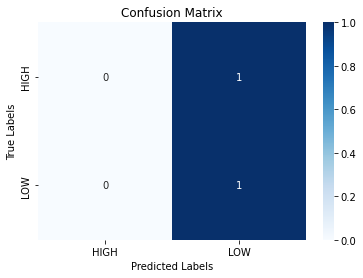

In [30]:
# Evaluate
best_model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('/model.pt', best_model, optimizer)
evaluate_full(best_model, test_iterator)